# Getting golestan captcha

In [1]:
import requests
import base64
import numpy as np
import time

url = 'https://edu.znu.ac.ir/Forms/AuthenticateUser/captcha.aspx?0.40381493127445034&x859=386&x763=844'
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36"}


for i in range(944,1000):
    x = requests.get(url, headers=headers, stream=True)

    a = x.content

    with open(f'./dataset-golestan/captcha{i}.jpg','wb') as f:
        f.write(a)
    delay = np.random.randint(2)
    time.sleep(10)

# Getting captcha from sheypoor website

In [11]:
import requests
import base64
import numpy as np
import time

url = 'https://www.sheypoor.com/api/web/captcha/refresh'
headers = {
    "authority": "www.sheypoor.com",
    "method": "POST",
    "path": "/api/web/captcha/refresh",
    "scheme": "https",
    "accept": "*/*",
    "accept-encoding": "gzip, deflate, br",
    "accept-language": "en-US,en;q=0.9",
    "content-length": "38",
    "content-type": "application/x-www-form-urlencoded; charset=UTF-8",
    "cookie": "plog=False; ts=b536dc923761e246fa3d552db50df071; track_id=e2e687919ce5e3f3a9a85f682145651c; AMP_TOKEN=%24NOT_FOUND; _ga=GA1.2.527994953.1644523644; _gid=GA1.2.672309292.1644523644; _gat=1",
    "origin": "https://www.sheypoor.com",
    # "referer": "https://www.sheypoor.com/%D9%81%D8%B1%D8%B2-%D8%A8%D8%B2%D8%B1%DA%AF-%D8%A7%D9%87%D9%86%DA%AF%D8%B1%DB%8C-%D8%B3%D9%86%DA%AF%D8%A8%D8%B1%DB%8C-%D8%AF%DB%8C%D9%85%D8%B1-%D8%AF%D8%A7%D8%B1-%D8%A8%D8%A7%D8%B3-402738844.html",
    "sec-ch-ua": '"Not A;Brand";v="99", "Chromium";v="98", "Google Chrome";v="98"',
    "sec-ch-ua-mobile": "?0",
    "sec-ch-ua-platform": "Windows",
    "sec-fetch-dest": "empty",
    "sec-fetch-mode": "cors",
    "sec-fetch-site": "same-origin",
    "user-agent": "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.82 Safari/537.36",
    "x-requested-with": "XMLHttpRequest"
}
data = {"token": "103159f5a73c63cacc4c9d8680d45325"}

for i in range(500,1000):
    x = requests.post(url, headers=headers, data=data, stream=True)

    a = x.json()['data']['image']
    a = a.encode('utf-8')

    with open(f'./dataset/captcha{i}.jpg','wb') as f:
        f.write(base64.decodebytes(a))
    delay = np.random.randint(5)
    # time.sleep(delay)

# preprocessing images

In [6]:
# LOADING IMAGES

import cv2
import os
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def load_images():
    root_path = os.getcwd()
    dataset_path = os.path.join(root_path, 'dataset')
    # dataset_path = os.path.join(root_path, 'dataset-golestan')
    images = [img for img in os.listdir(dataset_path)]
    return images, dataset_path

captcha13.jpg


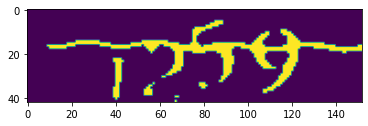

In [7]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# 501
# PREPROCESS LOADED IMAGES
def preprocessing(image, dataset_path):
    print(image)
    org_image = cv2.imread(os.path.join(dataset_path, image))
    image_gray = cv2.cvtColor(org_image, cv2.COLOR_RGB2GRAY)
    # crop_image = image_gray[:int(image_gray.shape[0]*0.9), :]
    crop_image = image_gray
    image_gray2 = cv2.blur(crop_image, (4,4))
    image_sharp = cv2.GaussianBlur(image_gray2, (0,0), sigmaX=1, sigmaY=20, borderType=cv2.BORDER_DEFAULT)
    # image_sharp = cv2.addWeighted(image_gray2, 2, image_sharp, -0.05, 0)
    image_sharp = cv2.addWeighted(image_gray2, 1.7, image_sharp, -0.01, 0)

    if image_sharp[0,0] and image_sharp[-1,-1] > 100:
        # print(image_sharp[0,0], image_sharp[-1,-1])
        image_sharp_not = cv2.bitwise_not(image_sharp)
        ret, image_zeroone = cv2.threshold(image_sharp_not, 20, 255, cv2.THRESH_BINARY)
        return image_zeroone, org_image
    else:
        print('dark bg', end=' | ')
        # print(image_sharp[0,0], image_sharp[-1,-1])
        return None, org_image


images, dataset_path = load_images()
preprocessed_image, org_image = preprocessing('captcha13.jpg', dataset_path)
if type(preprocessed_image) == np.ndarray:
    if np.max(np.histogram(preprocessed_image)[0]) < 6300:
        plt.imshow(preprocessed_image)
        plt.show()

In [254]:
cv2.imshow('name', image_gray)
# cv2.imshow('name', image_gray_not)
cv2.waitKey(0)
# closing all open windows 
cv2.destroyAllWindows()

# Detection

In [8]:
from sklearn.cluster import KMeans
import numpy as np

In [9]:
# GET WHITE PIXELS CORDINATION
def get_whitePX_cord(image):
    points = []
    k=0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if int(image[i,j]) == 255:
                points.append([i,j])
                k = k+1
    return points

whitePX_cord = get_whitePX_cord(preprocessed_image)

In [10]:
# FIND DIGIT'S CENTER CORDINATION VIA KMEANS
def get_digit_center_cord(cord):
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=20, init='k-means++', max_iter=int(1e40)).fit(cord)
    # kmeans.inertia_
    cluster_centers = kmeans.cluster_centers_
    return np.sort(cluster_centers, axis=0)

digits_center = get_digit_center_cord(whitePX_cord)

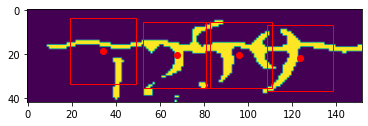

In [11]:
# PLOT IMAGE AND DRAW RECTANGULAR BOX AROUND DIGITS 
def display_results(digits_center):
    x = digits_center[:,0]
    y = digits_center[:,1]
    plt.imshow(preprocessed_image)
    plt.scatter(y,x, color='red')

    for center in digits_center:
        plt.gca().add_patch(Rectangle((center[1]-15,center[0]-15),30,30,linewidth=1,edgecolor='r',facecolor='none'))

display_results(digits_center)

# Extraxt separated number from each catpcha image

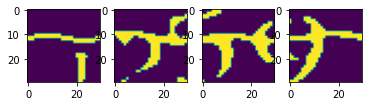

In [12]:
# EXTRACT DIGITS FROM AN IMAGE
def digits_extraction(digits_center, preprocessd_image):
    digits = []
    for center in np.round(digits_center):
        start_row = int(center[0]-15)
        start_col = int(center[1]-15)
        if start_row<0: start_row=0
        if start_col<0: start_col=0
        digit = preprocessd_image[start_row:start_row+30, start_col:start_col+30]
        digits.append(digit)
    return digits


extracted_digits = digits_extraction(digits_center, preprocessed_image)

for i, digit in enumerate(extracted_digits, 1):
    plt.subplot(1,4, i)
    plt.imshow(digit)

# GATHER ALL OF FUNCTION TOGETHER

In [ ]:
images = load_images()
# image = 'captcha137.jpg'
for image in images:
    preprocessed_image = preprocessing(image)[0]
    if type(preprocessed_image) == np.ndarray:
        if np.max(np.histogram(preprocessed_image)[0]) < 6300:
            whitePX_cord = get_whitePX_cord(preprocessed_image)
            digits_center = get_digit_center_cord(whitePX_cord)
            display_results(digits_center)
            extracted_digits = digits_extraction(digits_center, preprocessed_image)
            # plt.show()
            for i, digit in enumerate(extracted_digits, 1):
                plt.subplot(1,4, i)
                plt.imshow(digit)
                plt.show()
                plt.imsave(f'./digits-dataset/{image[:-4]}-{i}.jpg', digit)

# Convoloutional model

In [13]:
import pandas as pd

# LOAD DIGITS
X = []
for name in df['name']:
    path = os.path.join(os.getcwd(), 'digits-dataset/'+name+'.jpg')
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    X.append(np.array(image))
# X = np.asarray(X)


# LOAD LABELS DATA
with open('labels.txt') as f:
    labels = f.readlines()
    labels = [x.rstrip('\n') for x in labels]
    
labels = np.array([[x.split()[0], x.split()[1]] for x in labels])

df = pd.DataFrame(data={'name': labels[:,0],
                'digit': labels[:,1]})

df['digit'] = df['digit'].astype('int32')

# Colvoloutional Model

In [68]:
import tensorflow as tf
from keras.datasets import mnist
from keras import models
from keras import layers


(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

# plt.imshow(xtrain[0], cmap=plt.cm.binary)

xtrain = np.reshape(xtrain, (xtrain.shape[0], 28*28))
xtrin = xtrain.astype('float32') / 255

xtest = np.reshape(xtest, (xtest.shape[0], 28*28))
xtest = xtest.astype('float32') / 255


In [69]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [70]:
model.fit(
    xtrain,
    ytrain,
    verbose=1,
    epochs=3,
    batch_size=64,
    shuffle=True,
    validation_split=0.2,
)

Epoch 1/3
750/750 [==============================] - 14s 16ms/step - loss: 14.8422 - accuracy: 0.8468 - val_loss: 1.0217 - val_accuracy: 0.9339
Epoch 2/3
750/750 [==============================] - 12s 16ms/step - loss: 0.7893 - accuracy: 0.9461 - val_loss: 0.8785 - val_accuracy: 0.9498
Epoch 3/3
750/750 [==============================] - 15s 19ms/step - loss: 0.5831 - accuracy: 0.9631 - val_loss: 0.8034 - val_accuracy: 0.9589


In [88]:
ypred = model.predict(xtest[1:2])

np.argmax(ypred), ytest[1]

(2, 2)